In [1]:
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

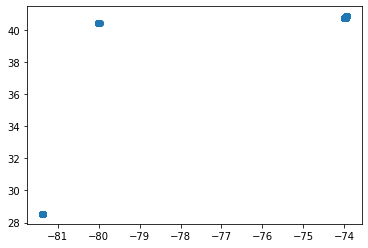

In [3]:
coords = sio.loadmat('data/GPS_Long_Lat_Compass.mat')['GPS_Compass']
plt.scatter(y=coords[:,0],x=coords[:,1])
plt.show()

As expected, the points are grouped into three clusters. These clusters are Pittsburgh, Manhattan, and Orlando

I want to get groupings for them, kmeans will probably be a convenient way of getting the correct label for each point. Given how far separated each city is from the others I can't imagine kmeans would have any trouble

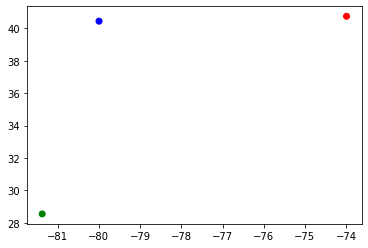

In [11]:
k3 = KMeans(n_clusters=3)
labels = k3.fit_predict(coords[:,:2])

plt.scatter(x=k3.cluster_centers_[:,1], y=k3.cluster_centers_[:,0], c=['red', 'green', 'blue'])
plt.show()

In [2]:
# Figure out which label corresponds to which city
#   Red => Manhattan
#   Green => Orlando
#   Blue => Pittsburgh
# Thus, 0:Man, 1:Orl, 2:Pit

# I can actually probably just train a model from here
from PIL import Image
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

In [ ]:
ohe = OneHotEncoder()
ohe_labels = ohe.fit_transform(labels.reshape(-1, 1))
ohe_labels = ohe_labels.todense()

In [3]:
def create_image_stack(imgid, imgfolder='data/images'):
    # 4 images per location
    imgs = np.array([
        np.asarray(Image.open(
             f'{imgfolder}/{imgid:06}_{i}.jpg'
        ).resize((90, 90)))
        for i in range(1, 5)
    ])
    # Who knows if this will perform well but whatever
    return imgs.reshape(180, 180, 3)

imgcount = 10343
# Split up into a test and train set
imgarr = np.arange(imgcount)
test = np.random.choice(imgarr, int(imgcount * 0.2))
train = np.setdiff1d(imgarr, test)

def create_batches(batchsize=32, source=train):
    # idk whether to do this inside or outside the function /shrug
    # Do I want to do this randomly?
    #    Yes. Yes I do.
    
    # The simplest will be a candidate list
    # Simplest to think about, I'm not in a position to consider optimization rn
    remain = source
    while len(remain) > 0:
        selection = np.random.choice(remain, batchsize)
        remain = np.setdiff1d(remain, selection)
        
        batch = np.array([
            create_image_stack(i + 1)
            for i in selection
        ])
        # Only take the lat/lon, ignore compass direction
        targets = ohe_labels[selection]
        yield (batch, targets)
        
def repeat_generator(genfunc, repeats=-1, **kwargs):
    # Numbers less than 0 will result in infinite repeats
    while repeats != 0:
        gen = genfunc(**kwargs)
        for res in gen:
            yield res
        repeats -= 1

In [26]:
model = Sequential()
model.add(Conv2D(64, 3, 3, input_shape=(180, 180, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [28]:
from tensorflow.keras.callbacks import EarlyStopping
stop = EarlyStopping(monitor='val_acc', patience=3)

model.fit(
    repeat_generator(create_batches),
    steps_per_epoch = len(train) // 32,
    epochs = 10,
    validation_data = repeat_generator(
        create_batches,
        source = test
    ),
    validation_steps = len(test) // 32,
    callbacks = [stop]
)

Epoch 1/10
264/264 [==============================] - 2058s 8s/step - loss: 26.8804 - acc: 0.7454 - val_loss: 0.6595 - val_acc: 0.7583
Epoch 2/10
264/264 [==============================] - 2137s 8s/step - loss: 0.3188 - acc: 0.9059 - val_loss: 0.5501 - val_acc: 0.8438
Epoch 3/10
264/264 [==============================] - 1982s 8s/step - loss: 0.0868 - acc: 0.9710 - val_loss: 0.5339 - val_acc: 0.8662
Epoch 4/10
264/264 [==============================] - 2098s 8s/step - loss: 0.0211 - acc: 0.9956 - val_loss: 0.6201 - val_acc: 0.8672
Epoch 5/10
264/264 [==============================] - 1937s 7s/step - loss: 0.0103 - acc: 0.9987 - val_loss: 0.6088 - val_acc: 0.8750
Epoch 6/10
264/264 [==============================] - 2073s 8s/step - loss: 0.0040 - acc: 0.9993 - val_loss: 0.6325 - val_acc: 0.8789
Epoch 7/10
264/264 [==============================] - 1944s 7s/step - loss: 0.0037 - acc: 0.9998 - val_loss: 0.7120 - val_acc: 0.8770
Epoch 8/10
264/264 [==============================] - 2170s 8

In [29]:
#model.save('models/classif/notest')
model.save('models/classif/tested')

INFO:tensorflow:Assets written to: models/classif/tested\assets


In [32]:
def make_prediction(imgid):
    pred = model.predict(np.array([create_image_stack(imgid)]))
    label = np.argmax(pred[0])
    return k3.cluster_centers_[label]

In [36]:
print(make_prediction(757))
print(coords[757])

# Predicted pittsburg
# Actual is pittsburg

[ 40.44056225 -79.99791908]
[ 40.442884 -80.0022    23.65    ]


In [37]:
print(make_prediction(10023))
print(coords[10023])
# Accurate prediction

[ 40.7436342  -73.98924638]
[ 40.736335 -74.006645 352.97    ]


In [47]:
# Try something from the test set, I have no idea if
# those two were training or testing
preds = model.predict(np.array([
    create_image_stack(i + 1)
    for i in test[:10]
]))
pred_labels = np.argmax(preds, axis=1)
print('Predicted:')
print(k3.cluster_centers_[pred_labels])

print('Actual:')
print(coords[test[:10]])

Predicted:
[[ 28.54581482 -81.37825776]
 [ 40.7436342  -73.98924638]
 [ 40.7436342  -73.98924638]
 [ 40.7436342  -73.98924638]
 [ 40.7436342  -73.98924638]
 [ 40.7436342  -73.98924638]
 [ 40.7436342  -73.98924638]
 [ 40.7436342  -73.98924638]
 [ 40.7436342  -73.98924638]
 [ 40.44056225 -79.99791908]]
Actual:
[[ 28.538436 -81.376605  85.06    ]
 [ 28.538366 -81.380028  92.09    ]
 [ 40.73242  -74.005609 227.11    ]
 [ 40.720347 -74.005256  16.98    ]
 [ 40.741265 -73.986862 111.15    ]
 [ 40.757663 -73.961387 324.23    ]
 [ 40.74439  -73.977068 299.35    ]
 [ 40.749956 -73.986094 268.67    ]
 [ 40.733528 -73.989868  96.96    ]
 [ 40.444722 -79.992649  53.44    ]]


So the predictions were:
* Correct (Orlando)
* Wrong (P: Manhattan, A: Orlando)
* Correct (Manhattan) x7
* Correct (Pittsburgh)

----

Load the preexisting model  
The class labels I have above are (0:Manhattan, 1:Orlando, 2:Pittsburgh), I don't remember if I re-clustered since making that note but I'm not going to wait for 6 hours to retrain the whole model. So if all three predictions are wrong but otherwise consistent with each other, I can try another set of three images. If the classes for the three new images agree with the old images I'll just assume my class labels got changed since that note was written.

In [4]:
model = tf.keras.models.load_model('models/classif/tested')
model

In [6]:
# Expect Manhattan: 0
pred = model.predict(np.array([create_image_stack(1, imgfolder='data/test_images')]))
print(pred)
print(np.argmax(pred[0]))
# Hmmm

[[1.7371638e-05 2.9362560e-14 9.9998260e-01]]
2


In [7]:
# Expect Pittsburgh: 2
pred = model.predict(np.array([create_image_stack(2, imgfolder='data/test_images')]))
print(pred)
print(np.argmax(pred[0]))
# Well that one was correct, I suppose?

[[8.226169e-08 9.037954e-08 9.999999e-01]]
2


In [8]:
# Expect Orlando: 1
pred = model.predict(np.array([create_image_stack(3, imgfolder='data/test_images')]))
print(pred)
print(np.argmax(pred[0]))
# That was also correct

[[1.1903577e-18 1.0000000e+00 1.7531285e-14]]
1


In [9]:
# Maybe that one image set from Manhattan just happened to hit the 20% incorrect
# Try another manhattan picture set
# This picture is pretty sunny, I wonder if it might mis-predict as Orlando
pred = model.predict(np.array([create_image_stack(4, imgfolder='data/test_images')]))
print(pred)
print(np.argmax(pred[0]))
# Pittsburgh again...

[[1.4234494e-02 1.1424698e-06 9.8576432e-01]]
2


These two cities are fairly similar latitudes, while Orlando is much farther south  
Perhaps if the predictions are relatively accurate in terms of latitude, then
there's some kind of confusion between Pittsburgh and Manhattan.

Looking closer at the actual prediction values, I do see the Orlando picture was 100% confident. While the others, while still being 99% confident, it is the other northern city that has a relatively high chance.  
That last prediction was only 98.5% confident in Pittsburgh, then Manhattan was a whole four orders of magnitude more likely than Orlando.

In [10]:
# Last attempt at Manhattan. These look like potential landmarks I suppose
pred = model.predict(np.array([create_image_stack(5, imgfolder='data/test_images')]))
print(pred)
print(np.argmax(pred[0]))
# Only 87% confident in Pittsburgh this time.
# Manhattan got above a single percentage point.

[[1.2951818e-01 2.3035345e-06 8.7047946e-01]]
2


Making predictions in bulk, and formatting nicely

In [11]:
truevals = pd.read_csv('data/test_coords.csv')
def make_prediction(imgids):
    preds = model.predict(np.array([
        create_image_stack(i, imgfolder='data/test_images')
        for i in imgids
    ]))
    pred_labels = np.argmax(preds, axis=1)
    result = pd.DataFrame({
        'Predicted': pred_labels,
        'Actual': truevals.City.iloc[np.subtract(imgids, 1)]
    })
    model_keys = {
        0: 'M',
        1: 'O',
        2: 'P'
    }
    result.Predicted = result.Predicted.map(model_keys)
    return result

In [12]:
pred_result = make_prediction(list(range(1, 11)))
acc = (pred_result.Predicted == pred_result.Actual).sum() / pred_result.shape[0]
print(acc)
pred_result[pred_result.Predicted != pred_result.Actual]

0.5


,Predicted,Actual
0,P,M
3,P,M
4,P,M
6,M,P
8,M,O


Predicted: Pittsburgh, Actual: Manhattan


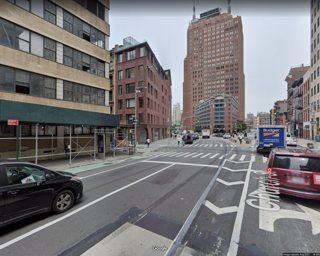

In [17]:
# Lets have a look at the incorrect images
print('Predicted: Pittsburgh, Actual: Manhattan')
Image.open('data/test_images/000001_1.jpg').resize((320, 256))

Predicted: Pittsburgh, Actual: Manhattan


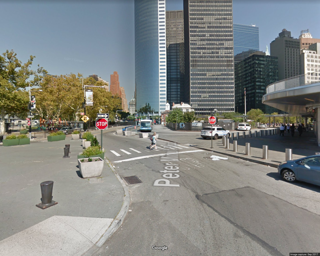

In [22]:
print('Predicted: Pittsburgh, Actual: Manhattan')
Image.open('data/test_images/000004_1.jpg').resize((320, 256))

Predicted: Pittsburgh, Actual: Manhattan


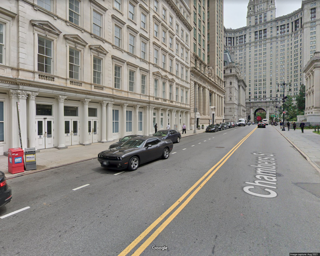

In [24]:
print('Predicted: Pittsburgh, Actual: Manhattan')
Image.open('data/test_images/000005_2.jpg').resize((320, 256))

Predicted: Manhattan, Actual: Pittsburgh


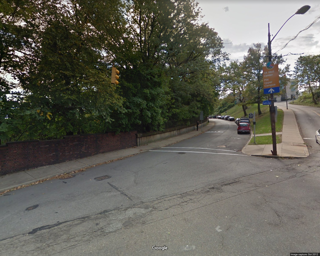

In [29]:
print('Predicted: Manhattan, Actual: Pittsburgh')
Image.open('data/test_images/000007_3.jpg').resize((320, 256))

Predicted: Manhattan, Actual: Orlando


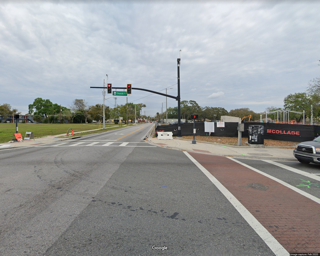

In [34]:
print('Predicted: Manhattan, Actual: Orlando')
Image.open('data/test_images/000009_1.jpg').resize((320, 256))

The mis-classification of Orlando at the end rather surprised me. The model thus far has been very good at predicting Orlando, while getting confused between Pittsburgh and Manhattan.